In [1]:
from sklearn.model_selection import train_test_split
from scipy.stats import t
import pandas as pd
import numpy as np
import time
from mgwr.gwr import GWR

In [2]:
#import data
df = pd.read_csv('../Data/2023_edges.csv', header =None)
with open('../Data/2023_edges_header.csv', 'r') as file:
    columns = file.readline().strip().split(',')
df.columns = columns
df_nodes = pd.read_csv('../Data/2023_nodes.csv', header =None)
with open('../Data/2023_nodes_header.csv', 'r') as file:
    columns = file.readline().strip().split(',')
df_nodes.columns = columns

df_edges_extended = pd.merge(df,df_nodes,left_on=':START_ID',right_on='stationId:ID')
df_edges_extended.rename(columns={'latitude:float':'start_latitude', 'longitude:float':'start_longitude'},inplace=True)
df_edges_extended.drop(['name',':LABEL','stationId:ID'],inplace=True,axis=1)
df_edges_extended = pd.merge(df_edges_extended,df_nodes,left_on=':END_ID',right_on='stationId:ID')
df_edges_extended.rename(columns={'latitude:float':'end_latitude', 'longitude:float':'end_longitude'},inplace=True)
df_edges_extended = df_edges_extended[['start_latitude', 'start_longitude','end_latitude','end_longitude', ':START_ID',':END_ID', 'month', 'day', 'hour',
       'temperature', 'wind_speed', 'distance','conditions']]
good_weather = [
    'Quelques nuages', 'Partiellement nuageux', 'Nuageux', 
    'Généralement nuageux. Risque de bruine verglaçante', 'Généralement nuageux', 
    'Généralement ensoleillé', 'Fumée', 'Ensoleillé', 'Dégagé', 
    'Couvert', 'Alternance de soleil et de nuages', 
    'Alternance de soleil et de nuages. Risque d\'orages'
]

# Create a new column to flag good weather
df_edges_extended['good_weather'] = df_edges_extended['conditions'].apply(lambda x: 1 if x in good_weather else 0)
#count departures/arrivals
departure_counts = df_edges_extended.groupby([":START_ID","start_longitude","start_latitude","temperature","wind_speed","good_weather","month","day","hour"]).size().reset_index(name='count')
arrival_counts = df_edges_extended.groupby([":END_ID","end_longitude","end_latitude","temperature","wind_speed","good_weather","month","day","hour"]).size().reset_index(name='count')
#prepare data for departure model
train, _ = train_test_split(departure_counts.iloc[:50000],train_size=0.8,random_state=42)
train_departure_variables = train[['temperature','wind_speed','good_weather','month','day','hour']].values
train_departure_locations = train[['start_longitude','start_latitude']].values
train_departure_count = train['count'].values.reshape((-1,1))
train_departure_features = train[['temperature','wind_speed','good_weather','month','day','hour','start_longitude','start_latitude']].values
train_departure_target = train['count'].values
#prepare data for arrival model
train, _ = train_test_split(arrival_counts.iloc[:50000],train_size=0.8, random_state=42)
train_arrival_variables = train[['temperature','wind_speed','good_weather','month','day','hour']].values
train_arrival_locations = train[['end_longitude','end_latitude']].values
train_arrival_count = train['count'].values.reshape((-1,1))
train_arrival_features = train[['temperature','wind_speed','good_weather','month','day','hour','end_longitude','end_latitude']].values
train_arrival_target = train['count'].values

In [3]:
#model MLR

class MultipleLinearRegression:
    def __init__(self, alpha=0.01):
        self.coefficients = None
        self.alpha = alpha  # Regularization parameter

    def fit(self, X, y):
        start_time = time.time()
        
        # Add a column of ones for the intercept term
        X = np.insert(X, 0, 1, axis=1)

        # Compute coefficients using the normal equation with regularization
        I = np.eye(X.shape[1])
        I[0, 0] = 0  # Do not regularize the intercept term
        self.coefficients = np.linalg.inv(X.T @ X + self.alpha * I) @ X.T @ y

        end_time = time.time()
        self.training_time = end_time - start_time

    def predict(self, X):
        start_time = time.time()

        # Add a column of ones for the intercept term
        X = np.insert(X, 0, 1, axis=1)

        if self.coefficients is None:
            raise ValueError("Model has not been trained yet. Please call fit() first.")
        
        predictions = X @ self.coefficients

        end_time = time.time()
        self.prediction_time = end_time - start_time

        return predictions

    def summary(self, X, y):
        if self.coefficients is None:
            raise ValueError("Model has not been trained yet. Please call fit() first.")
        
        X = np.insert(X, 0, 1, axis=1)
        n = X.shape[0]
        k = X.shape[1]

        # Predicted values
        y_pred = X @ self.coefficients

        # Residuals
        residuals = y - y_pred

        # Degrees of freedom
        df_total = n - 1
        df_model = k - 1
        df_residual = n - k

        # Sum of squares
        ss_total = np.sum((y - np.mean(y))**2)
        ss_residual = np.sum(residuals**2)
        ss_model = ss_total - ss_residual

        # Mean sum of squares
        ms_model = ss_model / df_model
        ms_residual = ss_residual / df_residual

        # R-squared and Adjusted R-squared
        r_squared = 1 - (ss_residual / ss_total)
        adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / df_residual)

        # Standard error of the coefficients
        var_b = ms_residual * np.linalg.inv(X.T @ X + self.alpha * np.eye(k))
        se_b = np.sqrt(np.diag(var_b))

        # t-values for the coefficients
        t_values = self.coefficients / se_b

        # p-values for the coefficients
        p_values = [2 * (1 - t.cdf(np.abs(i), df_residual)) for i in t_values]

        # F-statistic
        f_statistic = ms_model / ms_residual
        f_pvalue = 1 - t.cdf(f_statistic, df_model)

        summary_table = pd.DataFrame({
            "Coefficients": self.coefficients,
            "Standard Errors": se_b,
            "t-values": t_values,
            "p-values": p_values
        })

        metrics = {
            "R-squared": r_squared,
            "Adjusted R-squared": adj_r_squared,
            "F-statistic": f_statistic,
            "F-statistic p-value": f_pvalue
        }

        return summary_table, metrics

In [4]:
#train gwr
model_departure_gwr = GWR(train_departure_locations,train_departure_count,train_departure_variables,bw=0.1, kernel='bisquare')
results_departure_gwr = model_departure_gwr.fit()
model_arrival_gwr = GWR(train_arrival_locations,train_arrival_count,train_arrival_variables,bw=0.1, kernel='bisquare')
results_arrival_gwr = model_arrival_gwr.fit()
#train mlr
lr_model_departure = MultipleLinearRegression()
lr_model_departure.fit(train_departure_features, train_departure_target)
lr_model_arrival = MultipleLinearRegression()
lr_model_arrival.fit(train_arrival_features, train_arrival_target)

In [5]:
#Generate prediction of choice
coordinates = [[-73.551836,45.50761],[-73.541836,45.53761]] #longitude latitude
features = [[25,7,1,5,28,17],[23,6,2,8,29,16]] #temperature, windspeed, good_weather, month, day, hour
predict_station_location_gwr = np.array(coordinates)
predict_station_features_gwr = np.array(features)
predict_station_features_lr = np.concatenate((features,coordinates),axis=1)

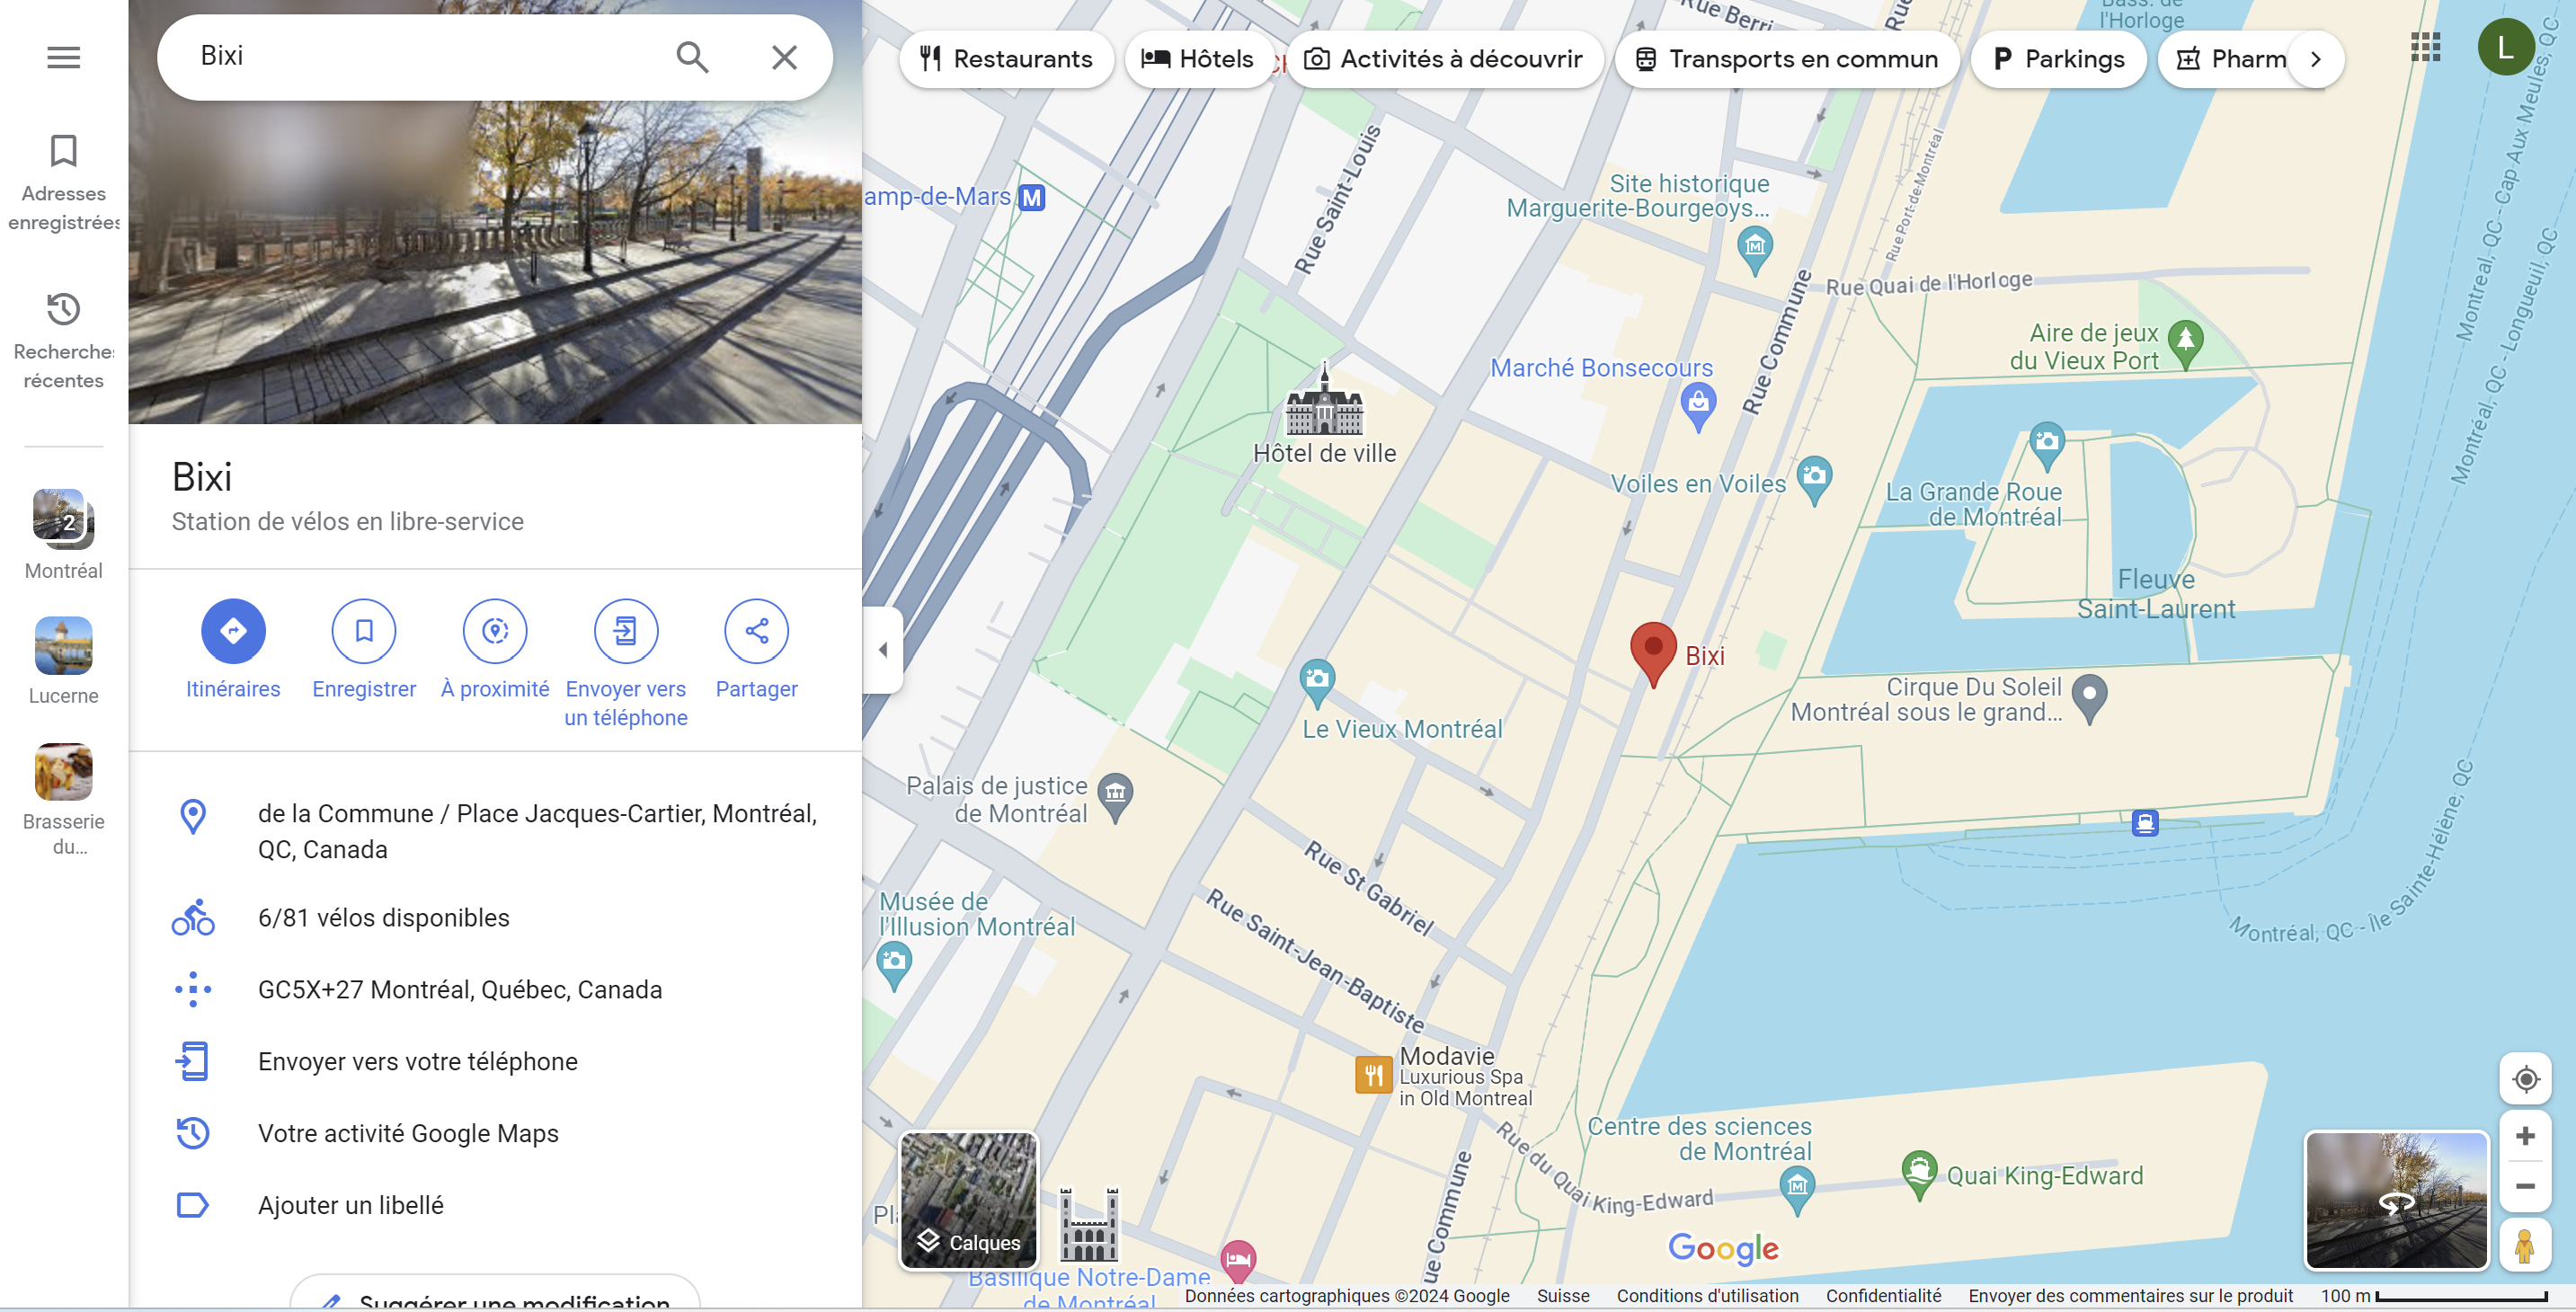

In [6]:
#Make the predictions:
pred_lr = lr_model_arrival.predict(predict_station_features_lr)- lr_model_departure.predict(predict_station_features_lr)
print(f"The flux for the station at coordinates {coordinates[0]}, the {features[0][4]}.{features[0][3]} at {features[0][5]}h will be: {pred_lr[0]}, according to MLR")
pred_gwr = model_arrival_gwr.predict(predict_station_location_gwr,predict_station_features_gwr).predy - model_departure_gwr.predict(predict_station_location_gwr,predict_station_features_gwr).predy
print(f"The flux for the station at coordinates {coordinates[0]}, the {features[0][4]}.{features[0][3]} at {features[0][5]}h will be: {pred_gwr[0]}, according to GWR")

The flux for the station at coordinates [-73.551836, 45.50761], the 28.5 at 17h will be: 0.42675841854998, according to MLR
The flux for the station at coordinates [-73.551836, 45.50761], the 28.5 at 17h will be: [3.25697976], according to GWR
